# 🥭 Workshop on **Spatial Multi-Criteria Assessment (SMCA)**  
### Locating Suitable Areas for Mango Cultivation  

**Module:** Geoprocesamiento – Maestría in Geomática. 
Universidad Nacional de Colombia
**Lecturer:** Liliana Castillo Villamor  
**Semester:** 2025-I  
**Key references:**  
- Keshkamat, S.S., Looijen, J.M. & Zuidgeest, M.H.P. (2009). *The formulation and evaluation of transport route planning alternatives: a spatial decision support system for the Via Baltica project.* **Journal of Transport Geography, 17**, 54-64.  
- CHARIM (2016). *Spatial Multi-Criteria Evaluation* chapter. <https://charim.net/methodology/65>  

---

In this workshop, you will develop a SMCA that pin-points the most suitable land for establishing mango production systems, integrating biophysical criteria

## Two-notebook structure

| Notebook | Main purpose | Key output |
|----------|--------------|------------|
| ** 1 – Data Rasterisation** | • Load DEM and vector layers (rivers, roads, protected areas)<br>• Reproject all vectors to the DEM’s CRS<br>• Derive slope and riparian buffers<br>• Rasterise every layer to match the DEM’s resolution and extent | Harmonised GeoTIFFs ready for analysis |
| ** 2 – SMCA & Suitability** | • Normalise factors (slope, proximity to roads/rivers)<br>• Apply constraints (protected zones, slope > 30 %, elevation > 1200 m, 30 m river buffer)<br>• Weight and combine factors under three policy visions (*Equal, Roads-priority, Slope-priority*)<br>• Map and classify final suitability | Suitability rasters (0–10) and categorical maps (High, Medium, Low, Restricted) |

*All GeoTIFFs produced in Notebook 1 are direct inputs for Notebook 2.*  


# 1. Introduction

Spatial Multi-Criteria Assessment (also called Spatial Multi-Criteria **Evaluation**, SMCE) is a GIS-based decision-support framework that blends the rigour of traditional MCDA with the explicit spatial representation of problems.  Its purpose is to turn heterogeneous geographic evidence (environmental, social, technical, economic) into transparent, reproducible **suitability maps** that can be debated and, ultimately, acted upon.  

Classic applications range from **linear-infrastructure routing**—e.g. the Via Baltica study by *Keshkamat et al.* (2009)—to **hazard-risk planning** in the Caribbean, as documented in the CHARIM methodology handbook (2016).  

> **Some references**  
> *Keshkamat, S.S., Looijen, J.M. & Zuidgeest, M.H.P. (2009).* The formulation and evaluation of transport route planning alternatives: a spatial decision support system for the Via Baltica project. **Journal of Transport Geography, 17**, 54-64.  
> CHARIM (2016). *Spatial Multi-Criteria Evaluation* chapter. <https://charim.net/methodology/65>

---

## From criteria to suitability

1. **Criteria definition** – the *thinking* stage  
   *Stakeholders articulate what matters.*  
   Here we separate each criterion into two logical types:

   * **Factors** – properties that contribute to suitability *by degree*.  
     - If *higher values help* (e.g. distance **to** roads for market access), the factor is treated as a **benefit**.  
     - If *higher values harm* (e.g. slope steepness), it becomes a **cost**.  
     Poor performance on one factor can, in principle, be compensated by good performance on another.

   * **Constraints** – “hard” exclusions where the activity is **never** allowed (e.g. protected areas, buffer strips, slopes > 30 %, elevations > 1200 m).  
     No amount of benefit elsewhere can over-ride a constraint.

2. **Standardisation** – the *translating* stage  
   Each factor—whether cost or benefit—is rescaled to a common, unit-free range (e.g. 0 – 10).  
   - **Benefit factors** are normalised so that higher raw values yield higher scores.  
   - **Cost factors** are inverted so that higher raw values yield lower scores.  
   Constraints are rasterised into a binary mask that will zero-out or tag prohibited cells.

3. **Weighting & aggregation** – the *balancing* stage  
   Stakeholders assign relative importance (weights) to the factors—often via pair-wise comparison (Saaty AHP).  
   Weighted factors are then summed to build a **composite suitability surface**, after which the constraint mask is applied, wiping out no-go pixels.

4. **Decision support** – the *using* stage  
   The final suitability map feeds routing algorithms, zoning rules or parcel selection.  Alternative weight sets (“policy visions”) expose the trade-offs between, say, economic access and ecological protection.  Sensitivity analysis checks the robustness of conclusions.

---

### Why this matters for our mango-cultivation case

* **Clear vocabulary** – by labelling slope as a *cost factor*, proximity to rivers/roads as *benefit factors*, and protected areas or steep slopes as *constraints*, we prevent hidden value judgements.  
* **Transparent maths** – anyone can trace a high-suitability pixel back to its weighted factor scores and confirm that no constraint was violated.  
* **Negotiable scenarios** – if policymakers later decide that water access should outweigh road proximity, we simply adjust weights and regenerate the map—no data re-engineering required.

> This workshop was created with support of AI. 




## 2. Setting the scene

### 1.1. Importing libraries

In [4]:
import geopandas as gpd       # used to handle shapefiles and other vector spatial data in Python
import numpy as np
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt  # Library for creating visualisations
import scipy.ndimage
import scipy.stats
import rasterio.merge
import rasterio.features
import matplotlib.pyplot as plt
from osgeo import gdal


### 1.2. Defining the input data paths

In [5]:
m_root=r"./data/SMCA"
carto_500k_path=m_root+"/Carto500000_Colombia_SD_2016.gpkg" # 1:500.000 cartography
dem_aoi_path=m_root+"/dem_aoi.tif" #DEM

dem_aoi_slope_path=m_root+"/dem_aoi_slope.tif" # This file wll be created as part of the notebook exercises
runap_path=m_root+"/runap.shp" # Path to protected areas shapefile

## 2.  Load and explore input data

#### 2.1. Inspecting and visualising the DEM  

The cell below **Loads the DEM raster**  using `rasterio.open`, then extracts and print some metadata (CRS, resolution, affine transform, etc.) so we can (a) confirm the coordinate reference system that all other layers must match, stores the transform and bounds for later plotting/alignmen, and displays the DEM in real-world coordinates, add a colour-bar for elevation, and overlay a simple grid.  


DEM metadata:
driver: GTiff
dtype: int16
nodata: -32768.0
width: 792
height: 1271
count: 1
crs: EPSG:4326
transform: | 0.00, 0.00,-73.24|
| 0.00,-0.00, 5.00|
| 0.00, 0.00, 1.00|


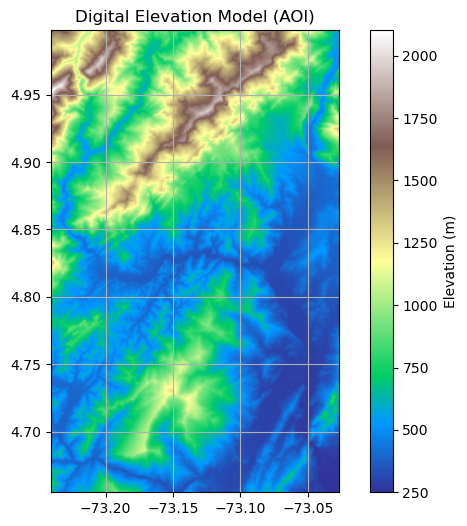

In [6]:
with rasterio.open(dem_aoi_path) as src:
    dem = src.read(1)  # Read the first (and only) band
    dem_meta = src.meta  # Mmetadata (CRS, resolution, transform, etc.)
    dem_bounds = src.bounds  # Get the geographical bounds of the raster
    transform = src.transform  # Affine transform (used for extent)

# Print DEM metadata 
print("DEM metadata:")
for key, value in dem_meta.items():
    print(f"{key}: {value}")

# Calculate extent in real-world coordinates (xmin, xmax, ymin, ymax)
extent = [dem_bounds.left, dem_bounds.right, dem_bounds.bottom, dem_bounds.top]

# Visualise the DEM with coordinates
plt.figure(figsize=(8, 6))
plt.imshow(dem, cmap="terrain", extent=extent, origin='upper')
plt.colorbar(label="Elevation (m)")
plt.title("Digital Elevation Model (AOI)")
plt.grid(True)
plt.show()


### 2.2. Inspecting and visualising vectorial data
Before extracting specific vector datasets, we need to understand the contents of the GeoPackage that contains Colombia’s 1:500,000 national cartography. This file includes multiple layers—such as roads, rivers, and other infrastructure—which we can inspect using the `Fiona` library. 

Fiona provides a Pythonic interface to GDAL’s OGR library, allowing us to list and access individual vector layers within the GeoPackage. In the code below, we list all available layers to identify which ones we will rasterise in the next steps.

In [7]:
# Import Fiona is a Python library for reading and writing vector data.
# It provides a simple interface to OGR (part of GDAL) for handling vector formats.
import fiona

# List all layers inside the GeoPackage
layers = fiona.listlayers(carto_500k_path)

print(" Layers found in the GeoPackage:")
for i, layer in enumerate(layers, start=1):
    print(f"{i}. {layer}")


 Layers found in the GeoPackage:
1. Arbol
2. Mina_P
3. Construccion_P
4. Planta_Tratamiento
5. Parque_P
6. Tapa_Camara
7. Central_Energia
8. Construccion_Agua_P
9. Administrativo_P
10. Otros_Textos
11. Antena
12. Puente_P
13. Poste
14. Peaje
15. Torre
16. Terminal_P
17. Paso_Nivel
18. Punto_Topografico
19. Hito_Limite
20. Punto_Nivelacion
21. Punto_Geodesico
22. Punto_Cota_Fotogrametrica
23. Punto_Aerotriangulacion
24. Punto_Estereoscopico
25. Modelo_de_Elevacion
26. Jaguey_P
27. Manantial
28. Costero_Insular
29. Nomenclatura
30. Orografia
31. Helipuerto_P
32. Aeropuerto_P
33. Puerto_P
34. Embarcadero_Muelle
35. Muro
36. Terraplen
37. Lote_L
38. Construccion_Agua_L
39. Cerca
40. Puente_L
41. Red_Alta_Tension
42. Tuberia
43. Tunel
44. Curva_Nivel
45. Lineas_de_Forma
46. Lineas_De_Quiebre
47. Raudal_Rapido
48. Linea_Costera
49. Catarata
50. Madrevieja_L
51. Canal_Sencillo
52. Drenaje_Sencillo
53. Pista_Aterrizaje_L
54. Via
55. Via_Ferrea
56. Limite_Via
57. Teleferico
58. Cicloruta
59. Zo

#### Load Specific Layers from GeoPackage: Rivers and Roads

Now that we know the names of the layers inside the GeoPackage, we can load the relevant ones using `geopandas.read_file()`.

We will load:
- The **`Drenaje_Sencillo`** layer (hydrography) into `gdf_rivers`
- The **`Via`** layer (roads) into `gdf_roads`


In [8]:
# Load the rivers layer
gdf_rivers = gpd.read_file(carto_500k_path, layer="Drenaje_Sencillo")

# Load the roads layer
gdf_roads = gpd.read_file(carto_500k_path, layer="Via")

# Load the protected area layer
gdf_runap = gpd.read_file(runap_path)
# Display basic info
print("✅ Layers successfully loaded.")

print("\n Rivers (Drenaje_Sencillo):")
display(gdf_rivers.head())

print("\n Roads (Via):")
display(gdf_roads.head())

print("\n Protected areas :")
display(gdf_runap.head())


c:\Users\VICTUS\anaconda3\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Non-conformant content for record 764 in column FECHA, 1899-12-31T00:00:00.0Z, successfully parsed
  return ogr_read(
c:\Users\VICTUS\anaconda3\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Non-conformant content for record 6 in column FECHA, 1899-12-30T00:00:00.0Z, successfully parsed
  return ogr_read(


✅ Layers successfully loaded.

 Rivers (Drenaje_Sencillo):


,NOMBRE_GEOGRAFICO,ESTADO_DRENAJE,PROYECTO,SYMBOL,FECHA,DISPERSION,geometry
0,Caño La Pedregosa,5101,None,2,NaT,,"MULTILINESTRING Z ((5.01e+06 2.56e+06 0, 5.01e..."
1,None,5101,None,2,NaT,,"MULTILINESTRING Z ((5.01e+06 2.56e+06 0, 5.01e..."
2,None,5101,None,,NaT,None,"MULTILINESTRING Z ((4.73e+06 2.29e+06 0, 4.73e..."
3,None,5101,None,2,NaT,None,"MULTILINESTRING Z ((4.66e+06 2.08e+06 0, 4.66e..."
4,,5101,None,2,NaT,,"MULTILINESTRING Z ((4.92e+06 2.18e+06 0, 4.92e..."



 Roads (Via):


,TIPO_VIA,ESTADO_SUPERFICIE,NUMERO_CARRILES,ACCESIBILIDAD,NOMBRE_GEOGRAFICO,PROYECTO,SYMBOL,FECHA,ESCALA,GLOBALID,geometry
0,6,Sin Valor,Sin Valor,Sin Valor,None,20,2,NaT,1.0,{A0B4FF57-9556-4C05-B344-B2F37FBB00A5},"MULTILINESTRING Z ((4.68e+06 1.81e+06 0, 4.68e..."
1,6,Sin Valor,Sin Valor,Sin Valor,None,20,2,NaT,1.0,{1040532C-E810-4BF6-9206-ED60D3902C6C},"MULTILINESTRING Z ((4.61e+06 1.81e+06 0, 4.61e..."
2,6,Sin Valor,Sin Valor,Sin Valor,None,20,2,NaT,1.0,{5EEA97C4-B76B-4C80-AA35-C7154FFE642E},"MULTILINESTRING Z ((4.58e+06 1.82e+06 0, 4.58e..."
3,5,3306,3502,3601,None,20,2,NaT,1.0,{B43DD4F9-0FD4-4AF7-ACD5-94DE4D67D30A},"MULTILINESTRING Z ((4.67e+06 1.82e+06 0, 4.67e..."
4,4,3306,3502,3600,None,20,2,NaT,1.0,{1AA6C115-8CEC-4D1A-9CF1-BD4E32C89689},"MULTILINESTRING Z ((4.61e+06 1.86e+06 0, 4.61e..."



 Protected areas :


,geometry
0,"POLYGON ((-76.098 1.6411, -76.098 1.641, -76.0..."
1,"POLYGON ((-72.068 2.373, -72.068 2.373, -72.06..."
2,"POLYGON ((-75.765 2.3877, -75.765 2.3871, -75...."
3,"POLYGON ((-75.506 1.7849, -75.506 1.7849, -75...."
4,"POLYGON ((-75.937 2.2066, -75.937 2.2061, -75...."


### 2.3. Plot Rivers and Roads on the Same Map

Let’s visualise both the `Drenaje_Sencillo` (rivers) and `Via` (roads) layers together.  
This will help us understand their spatial coverage and structure before rasterising or clipping.


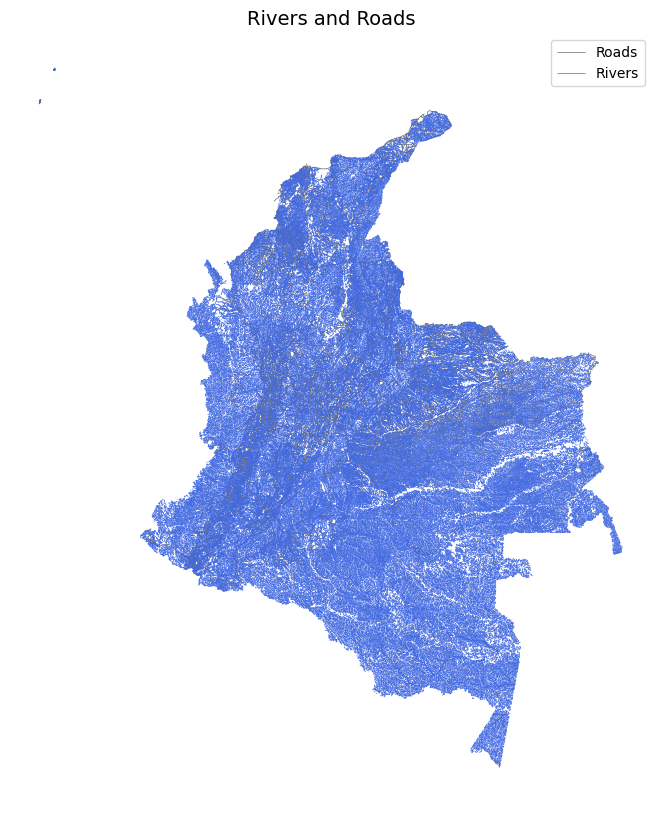

In [9]:

# Create a plot with both rivers and roads
fig, ax = plt.subplots(figsize=(10, 10))

# Plot roads in grey
gdf_roads.plot(ax=ax, linewidth=0.5, edgecolor='dimgray', label="Roads")

# Plot rivers in blue
gdf_rivers.plot(ax=ax, linewidth=0.5, edgecolor='royalblue', label="Rivers")

# Add title and legend
ax.set_title("Rivers and Roads", fontsize=14)
ax.legend(loc='upper right')
ax.set_axis_off()

plt.show()


### 2.4 Reprojecting the DEM to a common coordinate system

To ensure spatial consistency across all layers, the DEM is reprojected to the EPSG:9377 coordinate reference system. 


In [10]:
# Import functions for raster reprojection:
# - `calculate_default_transform`: computes the appropriate transform and dimensions for the new CRS.
# - `reproject`: performs the reprojection of raster data from source to destination CRS.
# - `Resampling`: provides methods for interpolating pixel values during reprojection.

from rasterio.warp import calculate_default_transform, reproject, Resampling

# Set the target Coordinate Reference System (CRS) for the project
target_crs = "EPSG:9377"

# Define the path to save the reprojected DEM
dem_reprojected_path = m_root + "/dem_aoi_epsg9377.tif"

# Open the original DEM and prepare reprojection 
with rasterio.open(dem_aoi_path) as src:
    
    # Calculate the transform and dimensions of the output raster in the target CRS
    transform, width, height = calculate_default_transform(
        src.crs,               # source CRS
        target_crs,            # target CRS
        src.width,             # width of the original raster
        src.height,            # height of the original raster
        *src.bounds            # bounding box of the original raster
    )

    # Copy the metadata and update it for the reprojected raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,     # update to new CRS
        'transform': transform,  # updated affine transform
        'width': width,          # new width
        'height': height         # new height
    })

    #  Perform the reprojection and save to new file
    with rasterio.open(dem_reprojected_path, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),         # input band from source raster
            destination=rasterio.band(dst, 1),    # destination band to write to
            src_transform=src.transform,          # original transform
            src_crs=src.crs,                      # original CRS
            dst_transform=transform,              # new transform
            dst_crs=target_crs,                   # new CRS
            resampling=Resampling.nearest         # use nearest-neighbour to preserve discrete values
        )

print(f" DEM reprojected and saved to: {dem_reprojected_path}")


 DEM reprojected and saved to: ./data/SMCA/dem_aoi_epsg9377.tif


## 3.  Derive Slope from DEM

In this section, we use GDAL's `DEMProcessing` tool to calculate the terrain slope from the DEM.  
The slope will be expressed in **percentage** and saved as a new GeoTIFF file.  
Slope is commonly used as a **cost factor** in spatial multi-criteria evaluations (SMCA), since steep areas are usually less suitable for development.


In [11]:
from osgeo import gdal

#  Generate slope in percentage using GDAL 
# The -p option in GDAL CLI corresponds to slopeFormat="percent" in Python API

gdal.DEMProcessing(
    destName=dem_aoi_slope_path,      # Output file path
    srcDS=dem_reprojected_path,               # Input DEM file
    processing="slope",               # Type of terrain processing
    format="GTiff",                   # Output format
    slopeFormat="percent"             # Output slope in percentage (%)
)

print("✅ Slope raster (percentage) has been successfully created.")


✅ Slope raster (percentage) has been successfully created.


### 3.1. Visualising the Slope Raster

After deriving the slope from the DEM, it is important to examine its values spatially. Slope is a critical constraint in land suitability analysis, as steep areas may be unsuitable for certain land uses, such as agriculture.

The following code reads the slope raster, calculates its spatial extent in real-world coordinates, and visualises it using a colour ramp. To avoid visual distortion due to extreme values or outliers, the colour scale is capped at the 99th percentile. This ensures a more interpretable visual representation of the slope distribution across the area of interest.


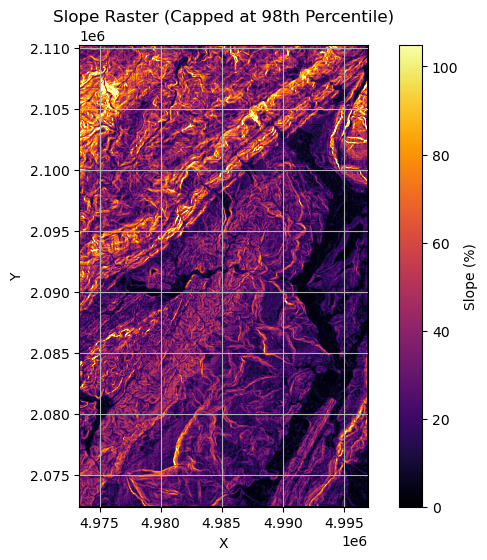

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Load the slope raster
with rasterio.open(dem_aoi_slope_path) as src:
    slope = src.read(1)
    slope_meta = src.meta
    slope_bounds = src.bounds

# Calculate extent for real-world coordinates
extent = [slope_bounds.left, slope_bounds.right, slope_bounds.bottom, slope_bounds.top]

# Calculate a threshold for visualisation (e.g. 98th percentile)
vmax = np.percentile(slope, 99)

# Plot with capped colour scale
plt.figure(figsize=(8, 6))
plt.imshow(slope, cmap="inferno", extent=extent, origin='upper', vmin=0, vmax=vmax)
plt.colorbar(label="Slope (%)")
plt.title("Slope Raster (Capped at 98th Percentile)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


### 3.2. Exploring the Distribution of Slope Values

Before applying slope thresholds for analysis, it is essential to explore the distribution of slope values across the study area. This helps identify suitable cut-off points for constraints and normalisation.

The code below performs basic statistical analysis on the slope raster, excluding no-data or invalid values. It prints key statistics such as minimum, maximum, mean, median, and key percentiles. A histogram is then plotted to visualise the frequency distribution of slope values, with the x-axis limited to the 99.9th percentile to reduce the influence of extreme outliers.


 Slope Raster Statistics
Min: 0.00 %
Max: 454.35 %
Mean: 33.07 %
Median: 28.77 %
98th percentile: 92.06 %
99.9th percentile: 167.51 %


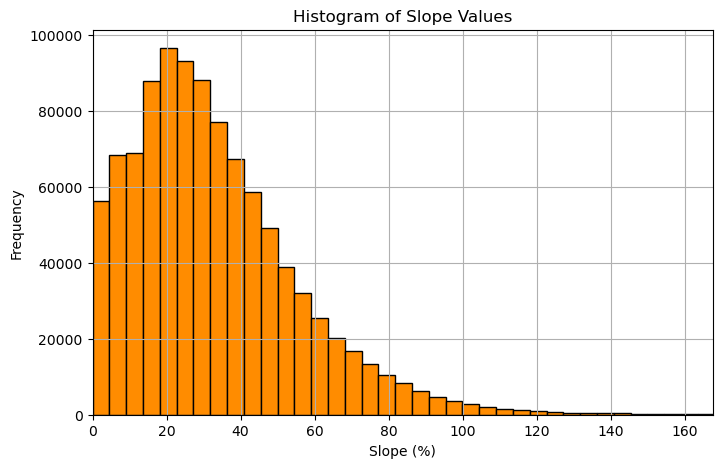

In [13]:
# Flatten the slope array and remove no-data or negative values (if any)
slope_valid = slope[(slope >= 0) & np.isfinite(slope)]

# Print key statistics
print(" Slope Raster Statistics")
print(f"Min: {np.min(slope_valid):.2f} %")
print(f"Max: {np.max(slope_valid):.2f} %")
print(f"Mean: {np.mean(slope_valid):.2f} %")
print(f"Median: {np.median(slope_valid):.2f} %")
print(f"98th percentile: {np.percentile(slope_valid, 98):.2f} %")
print(f"99.9th percentile: {np.percentile(slope_valid, 99.9):.2f} %")

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(slope_valid, bins=100, color="darkorange", edgecolor="black")
plt.title("Histogram of Slope Values")
plt.xlabel("Slope (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(0, np.percentile(slope_valid, 99.9))  # Limit x-axis to avoid extreme outliers
plt.show()


## 4. Check and Align CRS for All Vector Layers

In this step, we ensure that all vector layers (rivers, roads, protected areas) share the same Coordinate Reference System (CRS) as the DEM.


In [14]:
# Load the CRS from the reprojected DEM
with rasterio.open(dem_reprojected_path) as src:
    target_crs = src.crs

print(" Target CRS from reprojected DEM:", target_crs)

# Function to check and reproject GeoDataFrames if needed
def ensure_crs(gdf, target_crs, name=""):
    if gdf.crs != target_crs:
        print(f" Reprojecting '{name}' to match target CRS...")
        return gdf.to_crs(target_crs)
    else:
        print(f" '{name}' is already in the correct CRS.")
        return gdf

# Apply to each vector layer
gdf_rivers = ensure_crs(gdf_rivers, target_crs, "Rivers")
gdf_roads = ensure_crs(gdf_roads, target_crs, "Roads")
gdf_runap = ensure_crs(gdf_runap, target_crs, "Protected Areas")


 Target CRS from reprojected DEM: EPSG:9377
 'Rivers' is already in the correct CRS.
 'Roads' is already in the correct CRS.
 Reprojecting 'Protected Areas' to match target CRS...


### Visualising the Vector Layers: Rivers and Roads

This visualisation step provides an overview of the key linear infrastructure within the area of interest. The plot combines two vector layers—rivers and roads—onto a single map for spatial reference. A coordinate grid is included for spatial orientation, and axes are labelled using metric map units (metres). 


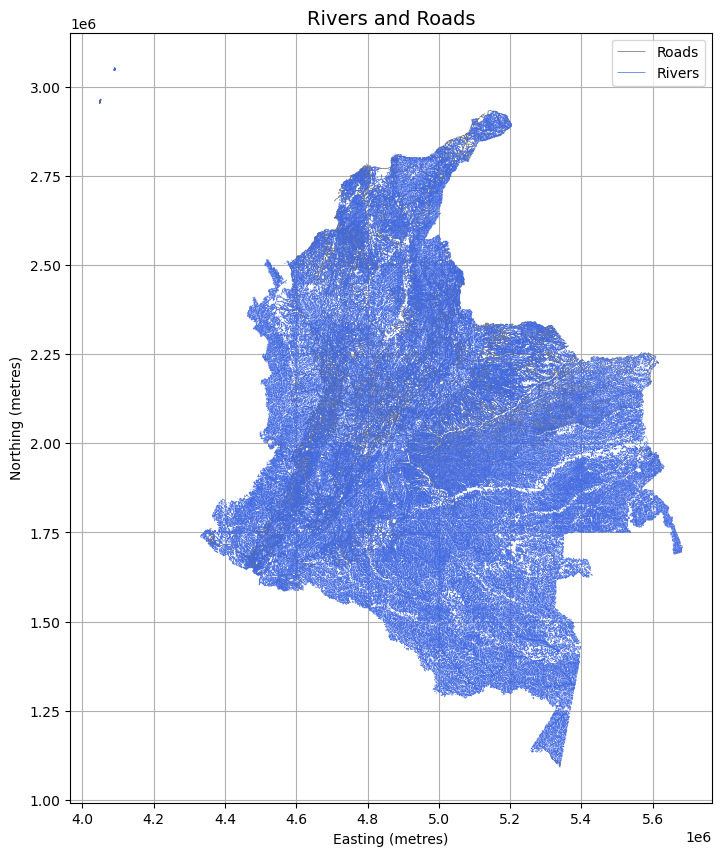

In [15]:
# Create a plot with both rivers and roads
fig, ax = plt.subplots(figsize=(10, 10))

# Plot roads in grey
gdf_roads.plot(ax=ax, linewidth=0.5, edgecolor='dimgray', label="Roads")

# Plot rivers in blue
gdf_rivers.plot(ax=ax, linewidth=0.5, edgecolor='royalblue', label="Rivers")

# Add title and legend
ax.set_title("Rivers and Roads", fontsize=14)
ax.legend(loc='upper right')

# Show coordinate grid and labels
ax.set_xlabel("Easting (metres)")
ax.set_ylabel("Northing (metres)")
ax.grid(True)

plt.show()


## 5. Rasterising Vector Layers to Match the DEM Grid

In order to conduct raster-based spatial analysis, vector datasets must first be converted into raster format. This section performs the following key operations:

1. **Load Reference Parameters**: The affine transform, coordinate reference system (CRS), and output shape are extracted from the reprojected Digital Elevation Model (DEM). These parameters ensure that all rasters created are spatially aligned.

2. **Define a Generic Rasterisation Function**: A reusable function `rasterise_layer()` is implemented to convert any input `GeoDataFrame` into a raster. The function assigns a value of `1` to all valid geometries and `0` elsewhere, preserving the shape, resolution, and extent of the reference DEM.

3. **Apply the Function to vector Layers**: 
   - Rivers (blue features)
   - Roads (linear grey infrastructure)
   - Protected areas (environmental constraints)

These raster layers serve as inputs for subsequent steps in the Spatial Multi-Criteria Assessment (SMCA).


In [16]:
import rasterio
from rasterio.features import rasterize
import numpy as np

# Load reference parameters from the reprojected DEM 
with rasterio.open(dem_reprojected_path) as src:
    dem_meta = src.meta
    transform = src.transform
    out_shape = (src.height, src.width)
    crs = src.crs

print("Reference transform and shape loaded from DEM")

#  Rasterise function 
def rasterise_layer(gdf, transform, out_shape, burn_value=1, layer_name="Layer"):
    """
    Rasterise a GeoDataFrame to match the reference raster grid.
    """
    if gdf.empty:
        print(f" {layer_name} is empty. Returning empty raster.")
        return np.zeros(out_shape, dtype="uint8")

    geometries = [(geom, burn_value) for geom in gdf.geometry if geom is not None]

    raster = rasterize(
        geometries,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype="uint8"
    )

    print(f" Rasterised: {layer_name}")
    return raster

#  Rasterise each vector layer 
rivers_raster = rasterise_layer(gdf_rivers, transform, out_shape, layer_name="Rivers")
roads_raster = rasterise_layer(gdf_roads, transform, out_shape, layer_name="Roads")
reserves_raster = rasterise_layer(gdf_runap, transform, out_shape, layer_name="Protected Areas")


Reference transform and shape loaded from DEM
 Rasterised: Rivers
 Rasterised: Roads
 Rasterised: Protected Areas


### 5.1. Visualising Rasterised Layers with Real-World Coordinates

This section visualises the rasterised outputs of roads, rivers, and protected areas. 

The axes are labelled in real-world map units (metres), and the grid provides spatial reference.


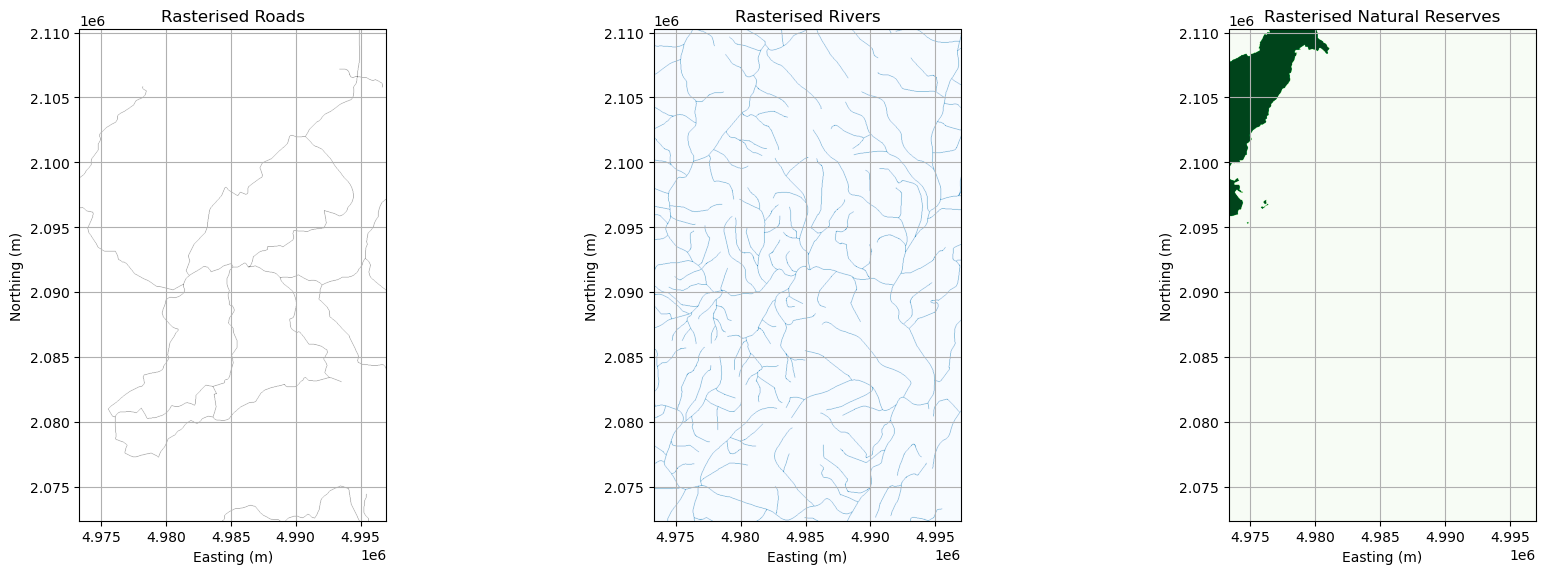

In [17]:
import matplotlib.pyplot as plt
from rasterio.transform import xy

# Visualise the results with real-world coordinates

# Compute extent from transform
xmin, ymax = transform * (0, 0)            # top-left corner
xmax, ymin = transform * (out_shape[1], out_shape[0])  # bottom-right corner
extent = [xmin, xmax, ymin, ymax]          # [left, right, bottom, top]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

im0 = axs[0].imshow(roads_raster, cmap="Greys", extent=extent, origin="upper")
axs[0].set_title("Rasterised Roads")
axs[0].set_xlabel("Easting (m)")
axs[0].set_ylabel("Northing (m)")
axs[0].grid(True)

im1 = axs[1].imshow(rivers_raster, cmap="Blues", extent=extent, origin="upper")
axs[1].set_title("Rasterised Rivers")
axs[1].set_xlabel("Easting (m)")
axs[1].set_ylabel("Northing (m)")
axs[1].grid(True)

im2 = axs[2].imshow(reserves_raster, cmap="Greens", extent=extent, origin="upper")
axs[2].set_title("Rasterised Natural Reserves")
axs[2].set_xlabel("Easting (m)")
axs[2].set_ylabel("Northing (m)")
axs[2].grid(True)

plt.tight_layout()
plt.show()


### 5.2. Save Rasterised Layers to Disk

The binary rasters for roads, rivers, and protected areas will now be saved as GeoTIFF files.  
They share the same extent, resolution, and CRS as the reprojected DEM (EPSG:9377).


In [18]:
print("🗺 Raster shapes (rows, cols):\n")

print(f"Roads raster:     {roads_raster.shape}")
print(f"Rivers raster:    {rivers_raster.shape}")
print(f"Reserves raster:  {reserves_raster.shape}")


🗺 Raster shapes (rows, cols):

Roads raster:     (1270, 794)
Rivers raster:    (1270, 794)
Reserves raster:  (1270, 794)


In [19]:
# Output paths
roads_raster_path = m_root + "/roads_raster_aoi.tif"
rivers_raster_path = m_root + "/rivers_raster_aoi.tif"
reserves_raster_path = m_root + "/reserves_raster_aoi.tif"

# Copy and force update of key metadata
raster_meta = dem_meta.copy()
raster_meta.update({
    "dtype": "uint8",
    "count": 1,
    "nodata": 0,
    "width": out_shape[1],
    "height": out_shape[0],
    "transform": transform
})

# Function to write a raster
def save_raster(array, path, meta, layer_name="Layer"):
    with rasterio.open(path, "w", **meta) as dst:
        dst.write(array, 1)
    print(f" Saved: {layer_name} → {path}")

# Save each layer
save_raster(roads_raster, roads_raster_path, raster_meta, "Roads")
save_raster(rivers_raster, rivers_raster_path, raster_meta, "Rivers")
save_raster(reserves_raster, reserves_raster_path, raster_meta, "Protected Areas")


 Saved: Roads → ./data/SMCA/roads_raster_aoi.tif
 Saved: Rivers → ./data/SMCA/rivers_raster_aoi.tif
 Saved: Protected Areas → ./data/SMCA/reserves_raster_aoi.tif
